### Module and Data Importation

In [109]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample
from bayes_opt import BayesianOptimization
import time
import matplotlib.pyplot as plt


In [70]:
X_train = pd.read_csv('C:/Users/Prathmun/Documents/Springboard Jupyter/Capstone 2/DataDataCapstone/derived_data/X_train_TS25_RS3.csv')
X_test = pd.read_csv('C:/Users/Prathmun/Documents/Springboard Jupyter/Capstone 2/DataDataCapstone/derived_data/X_test_TS25_RS3.csv')
y_train = pd.read_csv('C:/Users/Prathmun/Documents/Springboard Jupyter/Capstone 2/DataDataCapstone/derived_data/y_train_TS25_RS3.csv')
y_test = pd.read_csv('C:/Users/Prathmun/Documents/Springboard Jupyter/Capstone 2/DataDataCapstone/derived_data/y_test_TS25_RS3.csv')

# Problem Statements

In [72]:
print('problemtype: Medical : Catch all instances of event, false positives are less of a problem. Maximize: Recall')
print("problemtype: Spam: Catch most instances of event, minimize false positives. Deflect spam, without hiding real mail. Maximize Precision.")

problemtype: Medical : Catch all instances of event, false positives are less of a problem. Maximize: Recall
problemtype: Spam: Catch most instances of event, minimize false positives. Deflect spam, without hiding real mail. Maximize Precision.


### Helper Funcitons

In [73]:
def timing_buddy(model_to_fit, dictionary_string, dicto):
    funky_time_start = time.time()
    model_to_fit.fit(X_train, np.ravel(y_train))
    funky_time_stop = time.time()
    funky_train_time = funky_time_stop - funky_time_start
    dicto[dictionary_string]['training_time'] = funky_train_time
    

In [74]:
def confused_buddy(model_to_confuse, dictionary_string,dicto):
    confuse = confusion_matrix(y_test, model_to_confuse.predict(X_test))
    dicto[dictionary_string]['confuse'] = confuse

In [75]:
def recall_calculator(confuse):
    recall = 0
    tp = confuse[1][1]
    fn = confuse[1][0]
    if tp > 0 or tp ==1:
        recall = tp / (tp+fn)
    return recall

In [76]:
def precision_calculator(confuse):
    precision = 0
    tp = confuse[1][1]
    fp = confuse[0][1]
    if tp > 0 or tp ==1:
        precision = tp / (tp+fp)
    return precision

## Dummy

In [77]:
def classy_dummy(dicto, X_train, y_train, X_test, y_test):
    print('dumbo')
    dummy_clf = DummyClassifier(strategy="most_frequent")
    timing_buddy(dummy_clf, 'dummy', dicto)
    confused_buddy(dummy_clf, 'dummy', dicto)
    confused_buddy(dummy_clf, 'dummy', dicto)
    dicto['dummy']['ROC_AUC_Score'] = roc_auc_score(y_test, dummy_clf.predict_proba(X_test)[:, 1])
    

## SVC

In [78]:
def SVCmodeler(dicto, X_train, y_train, X_test, y_test):
    print('Support Vector Classification')
    SupportVectorClassifier = SVC()
    timing_buddy(SupportVectorClassifier, 'SVC', dicto)
    confused_buddy(SupportVectorClassifier, 'SVC', dicto)
    dicto['SVC']['ROC_AUC_Score'] = roc_auc_score(y_test, SupportVectorClassifier.decision_function(X_test))


## Stochastic Gradiant Descent 

In [79]:
def grid_sgd_model(dicto, X_train, y_train, X_test, y_test):
    
    def SGDHyperParameterer(loss_penalty_list):
        SGD_clf = SGDClassifier(loss = loss_penalty_list[0], penalty=loss_penalty_list[1])
        SGD_clf.fit(X_train, np.ravel(y_train))
        confuse = confusion_matrix(y_test, SGD_clf.predict(X_test))
        recall = recall_calculator(confuse)
        return recall
    
    
    losses= ['modified_huber', 'log']
    penalties = ['l2', 'l1', 'elasticnet']
    param_grid = {}
    count = 0
    for each_loss in losses:
        for each_penalty in penalties:
            param_grid[str(each_loss) + '-' + str(each_penalty)] = [each_loss, each_penalty]
            count+=1

    
    ###
    SGD_Hyper_param_recall_scores = {}
    for key, value in param_grid.items():
        SGD_Hyper_param_recall_scores[key] = SGDHyperParameterer(value)

    ###
    
    print('Stochastic Gradiant Descent')
    best_recall = 0
    penalty = ''
    loss = ''
    for key, value in SGD_Hyper_param_recall_scores.items():
        if value > best_recall:
            best_recall = value
            loss, penalty = key.split('-')
            
        
                                                                 
    
    ###
    SGD_clf = SGDClassifier(loss = loss, penalty= penalty)
    timing_buddy(SGD_clf, 'SGDClassfier', dicto)
    confused_buddy(SGD_clf, 'SGDClassfier', dicto)
    dicto['SGDClassfier']['ROC_AUC_Score'] = roc_auc_score(y_test, SGD_clf.decision_function(X_test))
    dicto['SGDClassfier']['Hyper_Params'] = {'Loss': loss, 'penalty':penalty}

## BaggingClassifier

In [80]:
def bayes_bagging_model(dicto, X_train, y_train, X_test, y_test):
    
    def bagginses_hyper(max_samples,max_features,n_estimators):
        Classy_Baggins_DT = BaggingClassifier(max_samples= max_samples,max_features = max_features, n_estimators=int(n_estimators))
        Classy_Baggins_DT.fit(X_train, np.ravel(y_train))
        confuse = confusion_matrix(y_test, Classy_Baggins_DT.predict(X_test))
        recall = recall_calculator(confuse)
        return recall


    
    ###
    pparams ={ 'max_samples': (.1,.9),
       'max_features' : (.1,.9),
       'n_estimators': (10,500)}

    ###
    
    optimizer = BayesianOptimization(
    bagginses_hyper,
    pbounds=pparams)
    
    ######
    
    print('Bagging Classifier')
    optimizer.maximize(init_points=15, n_iter=10)
    bagginses_params= optimizer.max
    bagginses_params = bagginses_params['params']
    
    ###
    Classy_Baggins_DT = BaggingClassifier(n_estimators=int(bagginses_params['n_estimators']), 
                                          max_features=bagginses_params['max_features'],
                                          max_samples =bagginses_params['max_samples'] )
    timing_buddy(Classy_Baggins_DT, 'BaggingClassifier', dicto)
    confused_buddy(Classy_Baggins_DT, 'BaggingClassifier', dicto)
    dicto['BaggingClassifier']['ROC_AUC_Score'] = roc_auc_score(y_test, Classy_Baggins_DT.predict_proba(X_test)[:, 1])
    dicto['BaggingClassifier']['Hyper_Params'] = bagginses_params

## Random Forest Model

In [81]:
def bayes_rf_model(dicto, X_train, y_train, X_test, y_test):
    
    def bayes_RFModeler_sqrt(n_estimators, 
                             max_depth,
                             min_samples_split,
                             min_samples_leaf):
        RandoForest = RandomForestClassifier(n_estimators=int(n_estimators), max_features='sqrt', max_depth=int(max_depth),
                                             min_samples_split=int(min_samples_split), min_samples_leaf=int(min_samples_leaf))
        RandoForest.fit(X_train, np.ravel(y_train))
        confuse = confusion_matrix(y_test, RandoForest.predict(X_test))
        recall = recall_calculator(confuse)
        return recall

    
    ###
    param_dicts = { 'n_estimators' : (100, 2000),
              'max_depth' : (10,60),
              'min_samples_split': (2,10),
              'min_samples_leaf' : (1,5),
              }
    ###
    
    optimizer = BayesianOptimization(
    bayes_RFModeler_sqrt,
    pbounds=param_dicts)
    
    ######
    
    print('Random Forest')
    optimizer.maximize(init_points=15, n_iter=10)
    rf_params= optimizer.max
    rf_params = rf_params['params']
    
    ###
    RandoForest = RandomForestClassifier(n_estimators=int(rf_params['n_estimators']), 
                                         max_features='sqrt',
                                         max_depth=int(rf_params['max_depth']),
                                         min_samples_split=int(rf_params['min_samples_split']),
                                         min_samples_leaf=int(rf_params['min_samples_leaf']))
    
    timing_buddy(RandoForest, 'RandomForestClassifier', dicto)
    confused_buddy(RandoForest, 'RandomForestClassifier', dicto)
    dicto['RandomForestClassifier']['ROC_AUC_Score'] = roc_auc_score(y_test, RandoForest.predict_proba(X_test)[:, 1])
    dicto['RandomForestClassifier']['Hyper_Params'] = rf_params

## AdaBooast Classifier

In [82]:
def bayes_hyper_ada_boost_model(dicto, X_train, y_train, X_test, y_test):
    
    def AdaBoost_hyper(n_estimators, learning_rate):
        adaira_the_classifier = AdaBoostClassifier(learning_rate=learning_rate,  n_estimators=int(n_estimators))
        adaira_the_classifier.fit(X_train, np.ravel(y_train))
        confuse = confusion_matrix(y_test, adaira_the_classifier.predict(X_test))
        recall = recall_calculator(confuse)
        return recall

    
    ###
    ada_params = {'learning_rate' : (.1,2),
              'n_estimators':(10,500),}
    ###
    
    optimizer = BayesianOptimization(
    AdaBoost_hyper,
    pbounds=ada_params)
    
    ######
    
    print('AdaBoost')
    optimizer.maximize(init_points=15, n_iter=10)
    ada_boost_params= optimizer.max
    ada_boost_params = ada_boost_params['params']
    
    ###
    adaira_the_classifier = AdaBoostClassifier(learning_rate=ada_boost_params['learning_rate'],  n_estimators=int(ada_boost_params['n_estimators']))
    timing_buddy(adaira_the_classifier, 'AdaBoostClassifier', dicto)
    confused_buddy(adaira_the_classifier, 'AdaBoostClassifier', dicto)
    dicto['AdaBoostClassifier']['ROC_AUC_Score'] = roc_auc_score(y_test, adaira_the_classifier.predict_proba(X_test)[:, 1])
    dicto['AdaBoostClassifier']['Hyper_Params'] = ada_boost_params

## Gradiant Boosting Model

In [83]:
def bayes_hyper_grad_boosting_model(dicto, X_train, y_train, X_test, y_test):
    
    def GradBoost_hyper(n_estimators, learning_rate, max_leaf_nodes):
        grady_the_boosted = GradientBoostingClassifier(learning_rate=learning_rate,  n_estimators=int(n_estimators),
                                                      max_leaf_nodes=int(max_leaf_nodes))
        grady_the_boosted.fit(X_train, np.ravel(y_train))
        confuse = confusion_matrix(y_test, grady_the_boosted.predict(X_test))
        recall = recall_calculator(confuse)
        return recall
    
    ###
    GradBoost_params = {'learning_rate' : (.1,2),
                    'n_estimators':(10,500),
                    'max_leaf_nodes':(3,50)}
    ###
    
    optimizer = BayesianOptimization(
    GradBoost_hyper,
    pbounds=GradBoost_params)
    
    ######
    
    print('Gradient Boosting')
    optimizer.maximize(init_points=15, n_iter=10)
    grad_boost_params= optimizer.max
    grad_boost_params = grad_boost_params['params']
    
    ###
    grady_the_boosted = GradientBoostingClassifier(learning_rate=grad_boost_params['learning_rate'],
                                                   n_estimators=int(grad_boost_params['n_estimators']),
                                                   max_leaf_nodes=int(grad_boost_params['max_leaf_nodes']))
    timing_buddy(grady_the_boosted, 'GradientBoostingClassifier', dicto)
    confused_buddy(grady_the_boosted, 'GradientBoostingClassifier', dicto)
    dicto['GradientBoostingClassifier']['ROC_AUC_Score'] = roc_auc_score(y_test, grady_the_boosted.predict_proba(X_test)[:, 1])
    dicto['GradientBoostingClassifier']['Hyper_Params'] = grad_boost_params
    

## HistGradientBoostingClassifier


In [84]:
def bayes_hyper_hist_grad_model(dicto, X_train, y_train, X_test, y_test):
    
    def histBoost_hyper(learning_rate, max_leaf_nodes):
        histamine_reaction = HistGradientBoostingClassifier(learning_rate=learning_rate,
                                                      max_leaf_nodes=int(max_leaf_nodes))
        histamine_reaction.fit(X_train, np.ravel(y_train))
        confuse = confusion_matrix(y_test, histamine_reaction.predict(X_test))
        recall = recall_calculator(confuse)
        return recall
    ###
    HistBoost_params = {'learning_rate' : (.1,2),
                    'max_leaf_nodes':(3,50)}
    ###
    optimizer = BayesianOptimization(
    histBoost_hyper,
    pbounds=HistBoost_params)
    
    ######
    
    print('HistGradient')
    optimizer.maximize(init_points=15, n_iter=10)
    hist_grad_params= optimizer.max
    print(hist_grad_params)
    hist_grad_params = hist_grad_params['params']
    ###
    histamine_reaction = HistGradientBoostingClassifier(learning_rate =hist_grad_params['learning_rate'],
                                                        max_leaf_nodes= int(hist_grad_params['max_leaf_nodes']))
    hist_time_start = time.time()
    histamine_reaction.fit(X_train, np.ravel(y_train))
    hist_time_stop = time.time()
    hist_train_time = hist_time_stop - hist_time_start
    ###
    dicto['HistGradientBoostingClassifier']['training_time'] = hist_train_time
    confuse = confusion_matrix(y_test, histamine_reaction.predict(X_test))
    dicto['HistGradientBoostingClassifier']['confuse'] = confuse
    dicto['HistGradientBoostingClassifier']['ROC_AUC_Score'] = roc_auc_score(y_test, histamine_reaction.predict_proba(X_test)[:, 1])    
    dicto['HistGradientBoostingClassifier']['Hyper_Params'] = hist_grad_params

## Model Evaluation

#precision = tp/(tp+fp)
maximize this for spam, don't wanna be hiding real emails

#recall= tp/(tp+fn) 
Maximize this for medical or security scenarios, don't wanna miss actual sicknesses

In [98]:
def medical_evaluator(dicto):
    bestmodel = ""
    training_time= 0
    recall = 0
    temp_recall = 0
    for key, value in dicto.items():
        
        confuse = dicto[key]['confuse']
        if type(confuse) != list:
            temp_recall = recall_calculator(confuse)

            if temp_recall > recall:

                recall = temp_recall
                bestmodel = key
                training_time = dicto[key]['training_time']
    return bestmodel, recall, training_time

In [99]:
def spam_evaluator(dicto):
    bestmodel = ""
    training_time= 0
    precision = 0
    temp_precision = 0.00000001
    for key, value in dicto.items():
        confuse = dicto[key]['confuse']
        if type(confuse) != list:
            temp_precision = precision_calculator(confuse)

            if temp_precision > precision:

                precision = temp_precision
                bestmodel = key
                training_time = dicto[key]['training_time']
    return bestmodel, precision, training_time

# Model Execution

### Aggregate Function

In [87]:
def chonky_model_aggregator(X_train, y_train, X_test, y_test):
    
    #Models to explore
    model_set = ['dummy','SVC', 'SGDClassfier', 'BaggingClassifier', 'RandomForestClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'HistGradientBoostingClassifier']
    model_stats = {}
    for each in model_set:
        model_stats[each] ={'confuse' : [], 'training_time' : 0, 'ROC_AUC_Score': 0, 'Hyper_Params': {}}
    #model running
    classy_dummy(model_stats, X_train, y_train, X_test, y_test)
    #SVC was taking a long time to train and doing very little for us
    #SVCmodeler(model_stats, X_train, y_train, X_test, y_test)
    grid_sgd_model(model_stats, X_train, y_train, X_test, y_test)
    #bagging hasn't been particularly impressive either
    
    #bayes_bagging_model(model_stats, X_train, y_train, X_test, y_test)
    #RF Takes a while to train, but's been leading the precision score
    bayes_rf_model(model_stats, X_train, y_train, X_test, y_test)
    #Previous trials showed that the ada boost is taking a while to train, and not leading the pack on any of the relevant scores.
    #bayes_hyper_ada_boost_model(model_stats, X_train, y_train, X_test, y_test)
    bayes_hyper_grad_boosting_model(model_stats, X_train, y_train, X_test, y_test)
    bayes_hyper_hist_grad_model(model_stats, X_train, y_train, X_test, y_test)


    #best_med_model, med_precision, med_time = medical_evaluator(model_stats)
    #best_spam_model, spam_recall, spam_time = spam_evaluator(model_stats)
    #print("The best medical model (Optimizing for precision) is " + best_med_model + " It's precision score was" + str(round(med_precision,3)) + " and it took " + str(round(med_time,2)) +" seconds to run.")
    #print("")
    #print("The best spam model (Optimizing for recall) is " + best_spam_model + " It's recall score was" +str(round(spam_recall, 3)) +" and it took " + str(round(spam_time, 2) +" seconds to run.")
    return model_stats



#Wide Data

### Stats Creation

#### Wide Stats

In [88]:
wide_data_model_stats = chonky_model_aggregator(X_train, y_train, X_test, y_test)

dumbo
Stochastic Gradiant Descent
Random Forest
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.08012  |  12.63    |  3.807    |  3.094    |  269.8    |
|  2        |  0.179    |  28.21    |  2.259    |  4.941    |  1.076e+0 |
|  3        |  0.1857   |  54.14    |  2.191    |  2.066    |  1.619e+0 |
|  4        |  0.04979  |  11.77    |  3.295    |  3.919    |  914.5    |
|  5        |  0.1441   |  18.07    |  4.507    |  8.336    |  818.9    |
|  6        |  0.1775   |  59.27    |  3.311    |  5.027    |  1.983e+0 |
|  7        |  0.1284   |  16.97    |  2.817    |  8.151    |  307.6    |
|  8        |  0.2007   |  49.67    |  1.473    |  3.083    |  1.159e+0 |
|  9        |  0.182    |  30.82    |  2.655    |  7.478    |  294.0    |
|  10       |  0.1689   |  24.69    |  3.5      |  8.219    |  628.0    |
|  11       |  0.1909   |  45.26    |  2.325    |  5.829    |  1

|  25       |  0.3003   |  1.103    |  48.34    |
{'target': 0.5001871958068139, 'params': {'learning_rate': 1.8714806005065374, 'max_leaf_nodes': 31.673856941244495}}


### Stats Examination

In [96]:
print(medical_evaluator(wide_data_model_stats))

('GradientBoostingClassifier', 0.35941594908274055, 33.10850119590759)


In [100]:
best_med_model, med_recall, med_time = medical_evaluator(wide_data_model_stats)
best_spam_model, spam_precision, spam_time = spam_evaluator(wide_data_model_stats)
print("The best medical model (Optimizing for recall) is " + best_med_model + " It's recall score was" + str(round(med_recall,3)) + " and it took " + str(round(med_time,2)) +" seconds to run.")
print("")
print("The best spam model (Optimizing for precision) is " + best_spam_model +
      " It's precision score was" +str(round(spam_precision, 3)) +" and it took " + str(round(spam_time, 2) ) +" seconds to run.")

The best medical model (Optimizing for recall) is GradientBoostingClassifier It's recall score was0.359 and it took 33.11 seconds to run.

The best spam model (Optimizing for precision) is RandomForestClassifier It's precision score was0.634 and it took 194.66 seconds to run.


In [117]:
for key, value in wide_data_model_stats.items():
    if value['training_time'] !=0:
        print(key)
        print('')
        for key2, value2 in value.items():
            print(key2)
            if key2 == 'confuse':
                if type(value2) != list:
                    print('recall: ' + str(round(recall_calculator(value2),2)))
                    print('precision: ' +str(round(precision_calculator(value2),2)))
            print(value2)
            print('')
        print('')
        print('')


dummy

confuse
recall: 0
precision: 0
[[10938     0]
 [ 2671     0]]

training_time
0.017004013061523438

ROC_AUC_Score
0.5

Hyper_Params
{}



SGDClassfier

confuse
recall: 0.34
precision: 0.53
[[10153   785]
 [ 1776   895]]

training_time
3.51579213142395

ROC_AUC_Score
0.7599344872864645

Hyper_Params
{'Loss': 'modified_huber', 'penalty': 'elasticnet'}



RandomForestClassifier

confuse
recall: 0.2
precision: 0.63
[[10634   304]
 [ 2145   526]]

training_time
194.65852546691895

ROC_AUC_Score
0.7740808802262423

Hyper_Params
{'max_depth': 49.67439573601397, 'min_samples_leaf': 1.4729797299636367, 'min_samples_split': 3.083254181658721, 'n_estimators': 1159.2621958539908}



GradientBoostingClassifier

confuse
recall: 0.36
precision: 0.47
[[9872 1066]
 [1711  960]]

training_time
33.10850119590759

ROC_AUC_Score
0.7494678319973598

Hyper_Params
{'learning_rate': 1.5933283538751961, 'max_leaf_nodes': 38.81617495990627, 'n_estimators': 174.24885414610273}



HistGradientBoostingClassif

In [103]:
grad_boost_params= {'learning_rate': 1.5933283538751961, 'max_leaf_nodes': 38.81617495990627, 'n_estimators': 174.24885414610273}

In [105]:
grady_the_boosted = GradientBoostingClassifier(learning_rate=grad_boost_params['learning_rate'],
                                               n_estimators=int(grad_boost_params['n_estimators']),
                                               max_leaf_nodes=int(grad_boost_params['max_leaf_nodes']))
grady_the_boosted.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(learning_rate=1.5933283538751961, max_leaf_nodes=38,
                           n_estimators=174)

drugs_sometimes                                0.810368
age                                            0.156517
drinks_very often                              0.017674
drugs_often                                    0.006474
religion_islam but not too serious about it    0.004097
hebrew                                         0.001680
drugs_never                                    0.000561
education_graduated from college/university    0.000546
drinks_often                                   0.000234
education_graduated from masters program       0.000210
dtype: float64


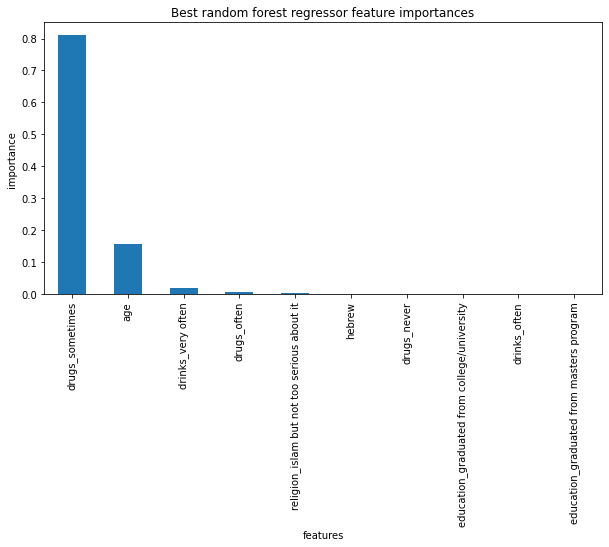

In [112]:
plt.subplots(figsize=(10, 5))
imps =grady_the_boosted.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.head(10).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');
print(rf_feat_imps.head(10))

In [114]:
rf_params = {'max_depth': 49.67439573601397, 'min_samples_leaf': 1.4729797299636367, 'min_samples_split': 3.083254181658721, 'n_estimators': 1159.2621958539908}

In [115]:
RandoForest = RandomForestClassifier(n_estimators=int(rf_params['n_estimators']), 
                                     max_features='sqrt',
                                     max_depth=int(rf_params['max_depth']),
                                     min_samples_split=int(rf_params['min_samples_split']),
                                     min_samples_leaf=int(rf_params['min_samples_leaf']))
RandoForest.fit(X_train, np.ravel(y_train))

RandomForestClassifier(max_depth=49, max_features='sqrt', min_samples_split=3,
                       n_estimators=1159)

age                                            0.066842
height                                         0.047286
drugs_sometimes                                0.043614
drugs_never                                    0.037397
multifluent_score                              0.024847
num_spoken                                     0.018609
drinks_often                                   0.017205
spanish                                        0.015333
ethnicity_multiplicity                         0.015150
white                                          0.011833
diet_anything                                  0.011819
religion_unspecified                           0.011673
drugs_unspecified                              0.011413
education_graduated from college/university    0.011335
pets_unspecified                               0.010891
dtype: float64


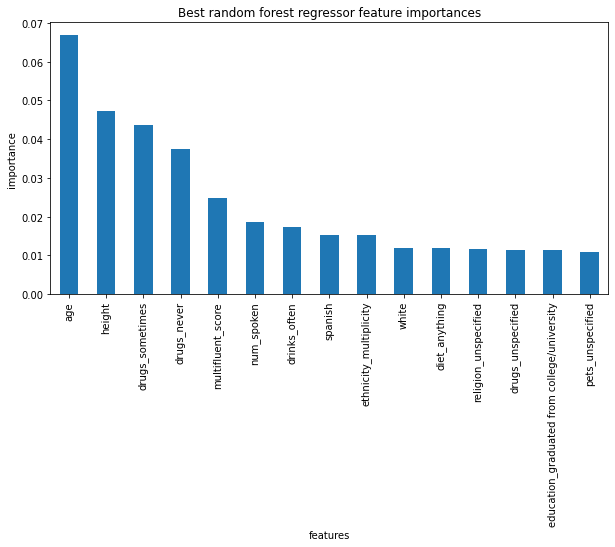

In [118]:
plt.subplots(figsize=(10, 5))
imps =RandoForest.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.head(15).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');
print(rf_feat_imps.head(15))